# Распознавание букв греческого алфавита методом k-ближайших соседей.

Импортируем необходимые библиотеки и модули.

In [1]:
import pandas as pd  # для работы с csv
import numpy as np
import random

from sklearn.preprocessing import StandardScaler  # для нормирования признаков модели
from sklearn.neighbors import KNeighborsClassifier  # классификатор на базе метода k-nears
from sklearn.metrics import accuracy_score, confusion_matrix  # доля правильных ответов и матрица несоответствий
from sklearn.model_selection import GridSearchCV  # для подбора оптимальных параметров

from matplotlib import pyplot as plt
%matplotlib inline

### 0. Предобработка данных датасета

Откроем обучающую выборку (https://www.kaggle.com/katianakontolati/classification-of-handwritten-greek-letters) букв греческого алфавита. Помимо необходимых нам 10 конкретных букв, датасет содержит и другие греческие буквы. В этой связи, в дальнейшем будет необходимо исключить из выборки лишние данные.

In [2]:
# путь до обучающей выборки
path = 'train.csv'

In [3]:
# попробуем открыть выборку в виде дата-фрейма
train_df = pd.read_csv(path, header=None)
print('Размер исходной выборки:', train_df.shape[0])
train_df.head()

Размер исходной выборки: 240


,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
0,255.0,247.0,251.0,255.0,249.0,255.0,245.0,254.0,254.0,254.0,...,255.0,253.0,254.0,255.0,255.0,245.0,255.0,238.0,255.0,1.0
1,252.0,255.0,249.0,254.0,253.0,255.0,255.0,247.0,254.0,255.0,...,241.0,255.0,253.0,248.0,255.0,255.0,255.0,255.0,234.0,1.0
2,244.0,255.0,253.0,246.0,255.0,248.0,255.0,249.0,251.0,249.0,...,255.0,255.0,255.0,255.0,239.0,255.0,255.0,252.0,255.0,1.0
3,255.0,246.0,255.0,246.0,255.0,255.0,243.0,255.0,255.0,233.0,...,247.0,255.0,247.0,246.0,248.0,255.0,255.0,243.0,247.0,1.0
4,251.0,255.0,255.0,249.0,255.0,255.0,249.0,251.0,254.0,255.0,...,255.0,235.0,255.0,245.0,255.0,248.0,255.0,255.0,240.0,1.0


Как можно заметить из представленной таблицы, каждая картинка кодируется матрицей размера 14 на 14 пикселей, для удобства переведенной в строку. После столбец таблицы отвечает за номер класса, к которому данная буква принадлежит, в соответствие со следующим правилом:

α ~ 1, β ~ 2, γ ~ 3, δ ~ 4, ε ~ 5, θ ~ 8, κ ~ 10, ρ ~ 17, χ ~ 22, ω ~ 24.

Нумерация идет непоследовательно в силу присутствия в выборке других букв греческого алфавита. После удаления последних пронумеруем буквы в соответствие с указанным списком от 0 до 9.

In [4]:
# преобразуем последний столбец к целочисленному типу
train_df = train_df.astype({196: int})

# перечислим метки тех букв, которые не нужны в дальнейшем
useless_labels = [6, 7, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23]

# удалим их
for lbl in useless_labels:
    train_df.drop(train_df[train_df[196] == lbl].index, inplace=True)
    
# выделим матрицу объектов-признаков
train = np.array(train_df.iloc[:, 0:196])
print('Размер преобразованной выборки:', train.shape)
print('Вид матрицы объектов-признаков:', train, sep='\n\n')

Размер преобразованной выборки: (100, 196)
Вид матрицы объектов-признаков:

[[255. 247. 251. ... 255. 238. 255.]
 [252. 255. 249. ... 255. 255. 234.]
 [244. 255. 253. ... 255. 252. 255.]
 ...
 [251. 255. 255. ... 255. 247. 255.]
 [255. 255. 250. ... 253. 253. 255.]
 [249. 253. 255. ... 255. 255. 255.]]


In [5]:
# выделим вектор целевых меток
labels = np.array(train_df.iloc[:, 196])
print('Размер целевого вектора:', labels.shape)

# перенумеруем метки вектора целевых меток от 0 до 9
lbl_dict = dict(zip(sorted(list(set(range(1, 25)) - set(useless_labels))), range(10)))
for i in range(len(labels)):
    labels[i] = lbl_dict[labels[i]]
print('Вид вектора целевых меток:', labels, sep='\n\n')

Размер целевого вектора: (100,)
Вид вектора целевых меток:

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]


В соответствие с проделанными выкладками, справедливы следующие обозначения:
- α ~ 0,
- β ~ 1,
- γ ~ 2,
- δ ~ 3,
- ε ~ 4,
- θ ~ 5,
- κ ~ 6,
- ρ ~ 7,
- χ ~ 8,
- ω ~ 9.

In [6]:
num2greek = {0: 'α', 1: 'β', 2: 'γ', 3: 'δ', 4: 'ε', 5: 'θ', 6: 'κ', 7: 'ρ', 8: 'χ', 9: 'ω'}

Проверим, как выглядит произвольная цифра из нашей выборки и совпадает ли она с целевой меткой.

Изображение буквы α номер под номером 8 в выборке:


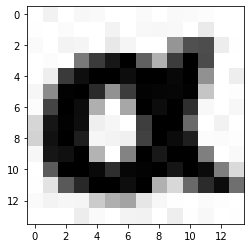

In [8]:
def show_rand_greek():
    r = random.randint(0, len(labels) - 1)
    print('Изображение буквы {} номер под номером {} в выборке:'.format(num2greek[labels[r]], r))
    plt.imshow(train[r].reshape(14, 14), cmap='gray')
    plt.show()
    

show_rand_greek()

Заметим, что пиксели, соответствующие букве имеют почти нулевую яркость, а остальной фон максимальную. Чтобы это исправить преобразуем матрицу, кроме того нормализуем её для дальнейшей работы алгоритма классификации.

In [9]:
# преобразуем выборку (ОСТОРОЖНО! если запустить блок снова, то выборка преобразуется обратно)
train = np.abs((train - 255) / (-255))

Изображение буквы χ номер под номером 80 в выборке:


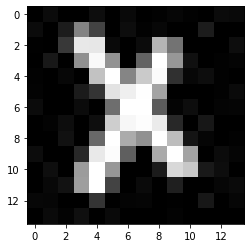

In [10]:
# проверяем
show_rand_greek()

Теперь аналогичные действия проделаем с отложенной тестовой выборкой.

In [11]:
# путь до тестовой выборки
path = 'test.csv'

# откроем выборку в виде дата-фрейма
test_df = pd.read_csv(path, header=None)
print('Размер исходной тестовой выборки:', test_df.shape[0])

# посмотрим на датафрейм
test_df.head()

Размер исходной тестовой выборки: 96


,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
0,253.0,255.0,255.0,251.0,244.0,255.0,254.0,253.0,248.0,255.0,...,255.0,247.0,255.0,255.0,251.0,249.0,255.0,254.0,237.0,1.0
1,248.0,255.0,245.0,255.0,255.0,247.0,255.0,247.0,255.0,236.0,...,252.0,255.0,247.0,240.0,255.0,253.0,240.0,255.0,241.0,1.0
2,255.0,255.0,254.0,255.0,252.0,242.0,255.0,245.0,244.0,255.0,...,255.0,251.0,251.0,255.0,255.0,253.0,251.0,249.0,255.0,1.0
3,255.0,249.0,252.0,248.0,254.0,255.0,246.0,252.0,244.0,255.0,...,255.0,233.0,246.0,252.0,249.0,255.0,254.0,241.0,255.0,1.0
4,255.0,252.0,255.0,255.0,254.0,244.0,244.0,255.0,255.0,243.0,...,253.0,232.0,240.0,242.0,255.0,255.0,255.0,239.0,241.0,2.0


In [12]:
# преобразуем последний столбец к целочисленному типу
test_df = test_df.astype({196: int})

# удалим записи, отвечающие за лишние буквы
for lbl in useless_labels:
    test_df.drop(test_df[test_df[196] == lbl].index, inplace=True)
    
# выделим матрицу объектов-признаков
test = np.array(test_df.iloc[:, 0:196])
print('Размер преобразованной тестовой выборки:', test.shape)
print('Вид матрицы объектов-признаков:', test, sep='\n\n')

Размер преобразованной тестовой выборки: (40, 196)
Вид матрицы объектов-признаков:

[[253. 255. 255. ... 255. 254. 237.]
 [248. 255. 245. ... 240. 255. 241.]
 [255. 255. 254. ... 251. 249. 255.]
 ...
 [246. 255. 255. ... 255. 239. 255.]
 [253. 255. 255. ... 247. 255. 252.]
 [255. 238. 255. ... 250. 255. 255.]]


In [13]:
# выделим вектор целевых меток
test_labels = np.array(test_df.iloc[:, 196])
print('Размер целевого вектора тестовой выборки:', test_labels.shape)

# перенумеруем метки вектора целевых меток от 0 до 9
for i in range(len(test_labels)):
    test_labels[i] = lbl_dict[test_labels[i]]
print('Вид вектора целевых меток тестовой выборки:', test_labels, sep='\n\n')

Размер целевого вектора тестовой выборки: (40,)
Вид вектора целевых меток тестовой выборки:

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8 9
 9 9 9]


In [14]:
# преобразуем тестовую выборку
test = np.abs((test - 255) / (-255))
print('Вид преобразованной матрицы объектов-признаков:', test, sep='\n\n')

Вид преобразованной матрицы объектов-признаков:

[[0.00784314 0.         0.         ... 0.         0.00392157 0.07058824]
 [0.02745098 0.         0.03921569 ... 0.05882353 0.         0.05490196]
 [0.         0.         0.00392157 ... 0.01568627 0.02352941 0.        ]
 ...
 [0.03529412 0.         0.         ... 0.         0.0627451  0.        ]
 [0.00784314 0.         0.         ... 0.03137255 0.         0.01176471]
 [0.         0.06666667 0.         ... 0.01960784 0.         0.        ]]


### 1. Обучение алгоритма k-ближайших соседей

In [15]:
# обучение классификатора k-ближайших соседей
model = KNeighborsClassifier()
model.fit(train, labels)

KNeighborsClassifier()

Модель обучена, теперь необходимо оценить её качество, для этого воспользуемся accuracy_score – доля правильных ответов на тестовой выборке.

In [16]:
train_predicted = model.predict(train)
print('Доля правильных ответов на обучающей выборке: ', accuracy_score(labels, train_predicted))
print('Истинные обучающие метки: \n', labels)
print('Предсказанные метки на обучающей выборке: \n', train_predicted)

Доля правильных ответов на обучающей выборке:  0.98
Истинные обучающие метки: 
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]
Предсказанные метки на обучающей выборке: 
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 5 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 1 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]


In [17]:
test_predicted = model.predict(test)
print('Доля правильных ответов на тестовой выборке: ', accuracy_score(test_labels, test_predicted))
print('Истинные тестовые метки: \n', test_labels)
print('Предсказанные метки на тестовой выборке: \n', test_predicted)

Доля правильных ответов на тестовой выборке:  0.925
Истинные тестовые метки: 
 [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8 9
 9 9 9]
Предсказанные метки на тестовой выборке: 
 [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 2 4 4 2 4 5 5 5 5 6 6 6 8 7 7 7 7 8 8 8 8 9
 9 9 9]


Проверим алгоритм для случайно взятого объекта из тестовой выборки.

На изображение №19 буква ε:


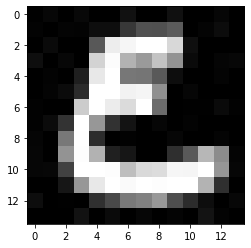

In [25]:
def show_rand_predict(X):  # X - текущая выборка
    r = random.randint(0, X.shape[0] - 1)
    print('На изображение №{} буква {}:'.format(r, num2greek[int(model.predict(X[r][np.newaxis, :]))]))
    plt.imshow(X[r].reshape(14, 14), cmap='gray')
    plt.show()
    
    
show_rand_predict(test)

В качестве еще одного критерия качества возьмем матрицу несоответствий и изобразим её графически.

In [26]:
# матрица несоответствий
confusion_mat = confusion_matrix(test_labels, test_predicted)
print('Матрица несоответсвий имеет вид: \n')
print(confusion_mat)

Матрица несоответсвий имеет вид: 

[[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 1 3 0 0 0 0 0 0]
 [0 0 1 0 3 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 3 0 1 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 4]]


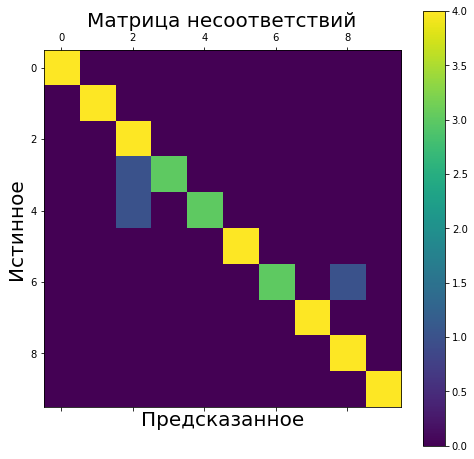

In [27]:
# то же самое графически
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

confusion_mat_colorbar = ax.matshow(confusion_mat)
plt.title('Матрица несоответствий', fontsize=20)
fig.colorbar(confusion_mat_colorbar)
plt.xlabel('Предсказанное', fontsize=20)
plt.ylabel('Истинное', fontsize=20)
plt.show()

### 2. Поиск оптимальных параметров модели по сетке

Для поиска оптимальных параметров воспользуемся функцией GridSearchCV, которая перебирает параметры классификатора на кросс-валидации. Отметим, что использовать только обучающую выборку здесь нецелесообразно, так она и так небольшая, а при кросс-валидации будет дробиться на еще более мелкие подвыборки. В этой связи далее будем использовать объединенную обучающую и тестовую выборки.

In [28]:
X = np.vstack((train, test))
print('Размер объединенной матрицы объекты-признаки: ', X.shape)
y = np.hstack((labels, test_labels))
print('Размер объединенного вектора меток классов: ', y.shape)

Размер объединенной матрицы объекты-признаки:  (140, 196)
Размер объединенного вектора меток классов:  (140,)


In [29]:
# параметры, подлежащие перебору на сетке
params = {"n_neighbors": np.arange(1, 11), 
          "metric": ["euclidean", "manhattan", "chebyshev"],
          "weights": ["uniform", "distance"]}
grid_cv = GridSearchCV(model, params, scoring='accuracy')

In [30]:
# поиск оптимальных параметров
grid_cv.fit(X, y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [31]:
# оптимальные параметры и лучший результат
print('Доля правильных ответов: ', grid_cv.best_score_)
print('Оптимальные параметры классификатора:\n', grid_cv.best_params_)

Доля правильных ответов:  0.95
Оптимальные параметры классификатора:
 {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


Проанализируем результат на матрице несоответствий.

In [32]:
# матрица несоответствий
y_predicted = grid_cv.best_estimator_.predict(X)
confusion_mat = confusion_matrix(y, y_predicted)
print('Матрица несоответсвий имеет вид: \n')
print(confusion_mat)

Матрица несоответсвий имеет вид: 

[[14  0  0  0  0  0  0  0  0  0]
 [ 0 13  1  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  1  0 13  0]
 [ 0  0  0  0  0  0  0  0  0 14]]


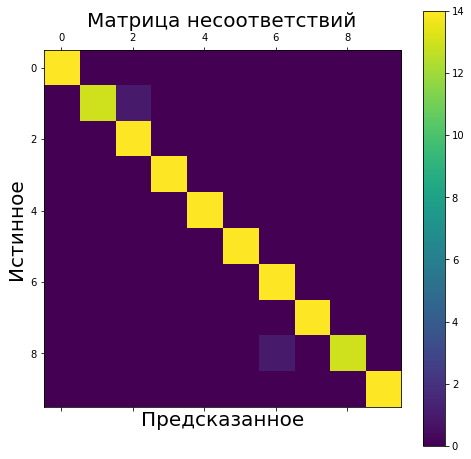

In [33]:
# то же самое графически
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

confusion_mat_colorbar = ax.matshow(confusion_mat)
plt.title('Матрица несоответствий', fontsize=20)
fig.colorbar(confusion_mat_colorbar)
plt.xlabel('Предсказанное', fontsize=20)
plt.ylabel('Истинное', fontsize=20)
plt.show()

### Обработка входных данных (изображений)

In [34]:
import skimage  # библиотека работы с изображениями
import skimage.transform  # модуль для преобразования изображений
import skimage.io  # input-out

import os  # библиотека работы с операционной системой
from natsort import natsorted # библиотека с функциями сортировки строк, содержащих числа

In [35]:
# директория датасета
files_dir = 'my_test_1'

files_list = os.listdir(files_dir)
image_list = []
for filename in files_list:
    image_list.append(skimage.io.imread(files_dir + '/' + filename))

print('Загружены следующие файлы:\n', *files_list, sep='\n')

Загружены следующие файлы:

0_alpha.jpg
1_beta.jpg
2_gamma.jpg
3_delta.jpg
4_epsilon.jpg
5_theta.jpg
6_kappa.jpg
7_ro.jpg
8_hi.jpg
9_omega.jpg


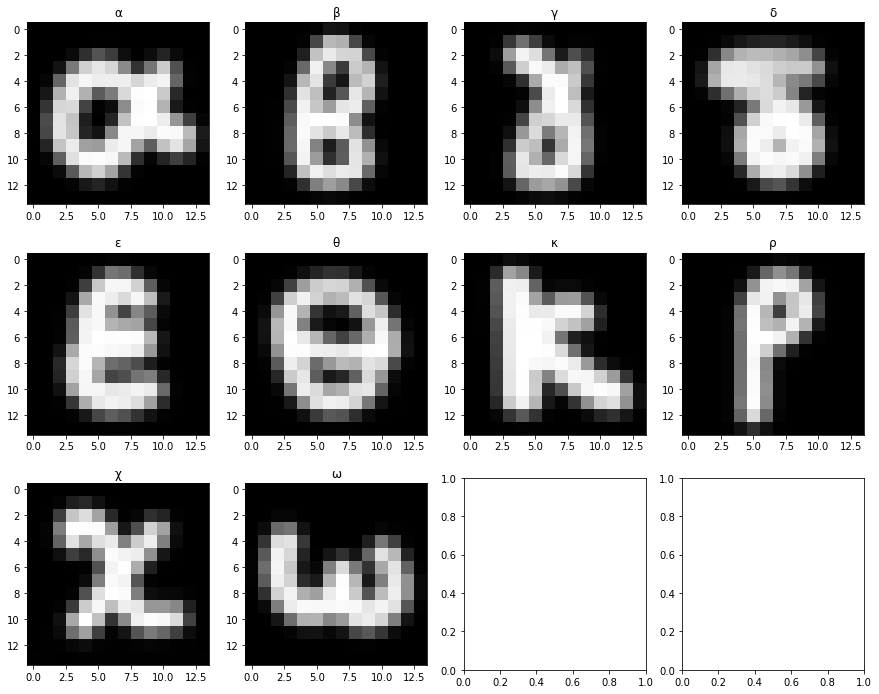

In [36]:
len_axes = (len(image_list) - 1) // 4 + 1
fig, axes = plt.subplots(nrows=len_axes, ncols=4, figsize=(15, 4 * len_axes))

# здесь храним предсказанные значения
predicted_greek = []

for i, img in enumerate(image_list):
    img_0 = img  # получаем исходное цветное изображение
    img_1 = skimage.color.rgb2gray(img_0)  # преобразуем к чб фото
    img_2 = skimage.transform.resize(img_1, (14, 14), anti_aliasing=True)  # приводим к разрешению 14 на 14
    img_3 = np.abs(img_2 - 1)  # инвертируем цвета

    # предсказываем букву
    pred = grid_cv.best_estimator_.predict(img_3.reshape((1, 196)))
    predicted_greek.append(int(pred))
    
    # рисуем буковку и пишем предсказание
    axes[i // 4, i % 4].imshow(img_3, cmap='gray')
    axes[i // 4, i % 4].set_title(str(num2greek[int(pred)]))